In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data
exp_name = "0zLGpNUa"                     # LZZkuGAZ   ibZ5x3E5  RGBS_p00     RGBSLANSHEGLA_p00_cleaned  t7Hiwh6A(2000+ boxes)   kzHjKthT (200+ boxes) ME0X3ynk aE4pm07D 8FU3FYuL 8asQEA6P (best so far) n8djAKPf

test_scores_path = f"/lustre_scratch/shaerdan/scores/test_scores_{exp_name}.nc"

ds_test = xr.open_dataset(test_scores_path)

print(ds_test)

save_plots_test = False


<xarray.Dataset>
Dimensions:               (box: 4630, channel: 1, y: 100, x: 100, tasmax_chan: 1, y2: 10, x2: 10, land_cover_chan: 1, tasmin_chan: 1, rainfall_chan: 1, model_output_channel: 1, model_output_y: 100, model_output_x: 100)
Coordinates:
  * y                     (y) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * x                     (x) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * channel               (channel) int64 0
Dimensions without coordinates: box, tasmax_chan, y2, x2, land_cover_chan, tasmin_chan, rainfall_chan, model_output_channel, model_output_y, model_output_x
Data variables: (12/24)
    ST_slices             (box, channel, y, x) float32 ...
    SW_corner_x           (box) int32 ...
    SW_corner_y           (box) int32 ...
    cloud_free_fractions  (box) float64 ...
    box_time              (box) datetime64[ns] ...
    x_eastings            (box, x) int32 ...
    ...                    ...
    rainfall_source       (box, rainfall_chan, y2, x2

In [2]:
# standardize the data for comparison

prediction = ds_test.hires_estimate.isel(model_output_channel=0)

ground_truth = ds_test.ST_slices.isel(channel=0)

ground_truth = ground_truth.drop_vars([coord for coord in ground_truth.coords if coord not in prediction.dims])
ground_truth.attrs.pop('units', None)
ground_truth.attrs.pop('standard_name', None)
prediction = prediction.rename({'model_output_y': 'y', 'model_output_x': 'x'})


print(prediction)
print(ground_truth)




<xarray.DataArray 'hires_estimate' (box: 4630, y: 100, x: 100)>
[46300000 values with dtype=float64]
Dimensions without coordinates: box, y, x
<xarray.DataArray 'ST_slices' (box: 4630, y: 100, x: 100)>
[46300000 values with dtype=float32]
Dimensions without coordinates: box, y, x


In [3]:

prediction = prediction.assign_coords(box_time=ds_test.box_time)
ground_truth = ground_truth.assign_coords(box_time=ds_test.box_time)

prediction_by_month = prediction.groupby('box_time.month')
ground_truth_by_month = ground_truth.groupby('box_time.month')

january_indices = prediction_by_month.groups[1]

prediction_january = prediction.sel(box=january_indices)
ground_truth_january = ground_truth.sel(box=january_indices)

print(prediction_january)
print(ground_truth_january)


<xarray.DataArray 'hires_estimate' (box: 119, y: 100, x: 100)>
[1190000 values with dtype=float64]
Coordinates:
    box_time  (box) datetime64[ns] 2016-01-20T11:11:01 ... 2022-01-07T10:52:39
Dimensions without coordinates: box, y, x
<xarray.DataArray 'ST_slices' (box: 119, y: 100, x: 100)>
[1190000 values with dtype=float32]
Coordinates:
    box_time  (box) datetime64[ns] 2016-01-20T11:11:01 ... 2022-01-07T10:52:39
Dimensions without coordinates: box, y, x


Month 1: 119 boxes
Month 2: 308 boxes
Month 3: 367 boxes
Month 4: 471 boxes
Month 5: 361 boxes
Month 6: 696 boxes
Month 7: 624 boxes
Month 8: 625 boxes
Month 9: 403 boxes
Month 10: 327 boxes
Month 11: 255 boxes
Month 12: 74 boxes


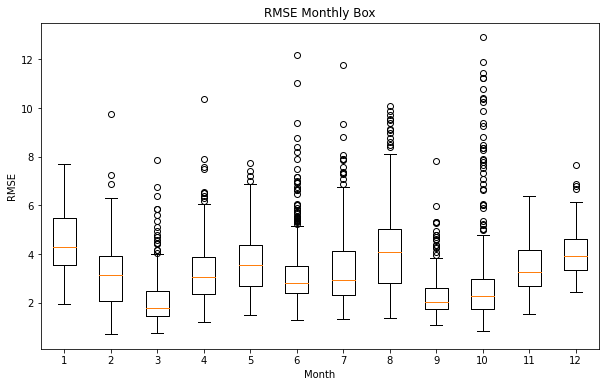

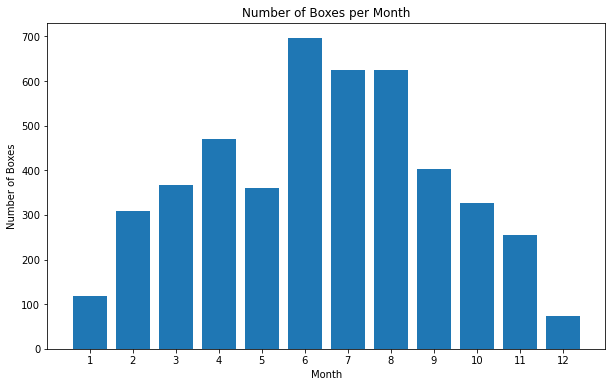

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def rmse(pred, true):
    return np.sqrt(((pred - true) ** 2).mean(dim=['y', 'x']))

prediction = prediction.assign_coords(box_time=ds_test.box_time)
ground_truth = ground_truth.assign_coords(box_time=ds_test.box_time)

rmse_per_box = rmse(prediction, ground_truth)

rmse_per_box_by_month = rmse_per_box.groupby('box_time.month')

rmse_values_by_month = []
box_count_by_month = []

for month in range(1, 13):
    if month in rmse_per_box_by_month.groups:
        month_indices = rmse_per_box_by_month.groups[month]
        rmse_month = rmse_per_box.sel(box=month_indices)
        rmse_values_by_month.append(rmse_month.values)
        box_count_by_month.append(len(month_indices))
    else:
        box_count_by_month.append(0)

for month, count in zip(range(1, 13), box_count_by_month):
    print(f"Month {month}: {count} boxes")

plt.figure(figsize=(10, 6))
plt.boxplot(rmse_values_by_month, labels=[str(month) for month in range(1, 13) if month in rmse_per_box_by_month.groups])
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.title('RMSE Monthly Box')
plt.show()    
    
plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), box_count_by_month, tick_label=[str(month) for month in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes per Month')
plt.show()



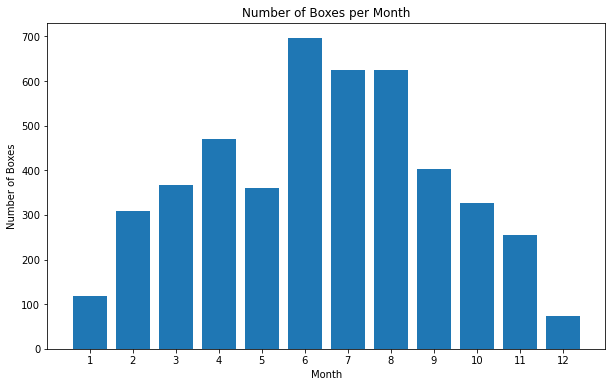

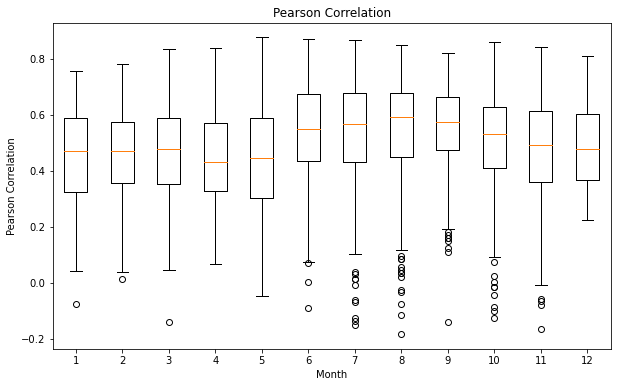

Month 1 outliers:
2016-01-20T11:11:01.000000000
Month 2 outliers:
2021-02-27T11:05:09.000000000
Month 3 outliers:
2020-03-28T11:04:53.000000000
Month 6 outliers:
2018-06-27T11:04:10.000000000
2022-06-22T11:05:22.000000000
2013-06-04T11:13:22.000000000
Month 7 outliers:
2014-07-02T11:04:56.000000000
2021-07-21T11:05:07.000000000
2013-07-06T11:12:55.000000000
2014-07-25T11:10:49.000000000
2014-07-25T11:10:49.000000000
2014-07-25T11:10:49.000000000
2014-07-25T11:10:49.000000000
2014-07-25T11:10:49.000000000
2019-07-23T11:10:55.000000000
2019-07-23T11:10:55.000000000
Month 8 outliers:
2022-08-09T11:05:38.000000000
2022-08-25T11:05:41.000000000
2022-08-25T11:05:41.000000000
2016-08-15T11:11:00.000000000
2016-08-15T11:11:00.000000000
2016-08-15T11:11:00.000000000
2016-08-15T11:11:00.000000000
2016-08-15T11:11:00.000000000
2018-08-05T11:10:16.000000000
2019-08-24T11:11:06.000000000
2019-08-24T11:11:06.000000000
2019-08-24T11:11:06.000000000
2019-08-24T11:11:06.000000000
Month 9 outliers:
2021

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def pearson_correlation(pred, true):
    pred_flat = pred.stack(z=['y', 'x'])
    true_flat = true.stack(z=['y', 'x'])
    
    pred_mean = pred_flat.mean(dim='z')
    true_mean = true_flat.mean(dim='z')
    
    pred_anomaly = pred_flat - pred_mean
    true_anomaly = true_flat - true_mean
    
    covariance = (pred_anomaly * true_anomaly).mean(dim='z')
    pred_std = pred_anomaly.std(dim='z')
    true_std = true_anomaly.std(dim='z')
    
    correlation = covariance / (pred_std * true_std)
    return correlation

prediction = prediction.assign_coords(box_time=ds_test.box_time)
ground_truth = ground_truth.assign_coords(box_time=ds_test.box_time)

correlation_per_box = pearson_correlation(prediction, ground_truth)

correlation_per_box_by_month = correlation_per_box.groupby('box_time.month')

correlation_values_by_month = []
box_count_by_month = []
outlier_dates_by_month = {}

for month in range(1, 13):
    if month in correlation_per_box_by_month.groups:
        month_indices = correlation_per_box_by_month.groups[month]
        correlation_month = correlation_per_box.sel(box=month_indices)
        correlation_values_by_month.append(correlation_month.values)
        box_count_by_month.append(len(month_indices))
        
        if correlation_month.size > 0:
            # Identify outliers
            Q1 = np.percentile(correlation_month, 25)
            Q3 = np.percentile(correlation_month, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = correlation_month.where((correlation_month < lower_bound) | (correlation_month > upper_bound), drop=True)
            if outliers.size > 0:
                # Filter the dates to include only those within the current month
                month_dates = prediction.sel(box=month_indices).box_time
                outlier_dates = month_dates.sel(box=outliers.box).values
                outlier_dates_by_month[month] = outlier_dates
    else:
        box_count_by_month.append(0)

# for month, count in zip(range(1, 13), box_count_by_month):
#     print(f"Month {month}: {count} boxes")
# print(f"Total number of boxes: {sum(box_count_by_month)}")

plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), box_count_by_month, tick_label=[str(month) for month in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes per Month')
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(correlation_values_by_month, labels=[str(month) for month in range(1, 13) if month in correlation_per_box_by_month.groups])
plt.xlabel('Month')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation')
plt.show()

for month, dates in outlier_dates_by_month.items():
    print(f"Month {month} outliers:")
    for date in dates:
        print(date)